In [3]:
import nanomotif as nm
import logging as log
import polars as pl


import matplotlib.pyplot as plt
import seaborn as sns
import re
import numpy as np
padding = 12


# Intro

Documentation of considerations in the implementation of the candidate selection. 

The selection is based on the sequences around methylation sites on the contig. At each methylated position, a frame of n posiion on each side of the methylation side is extracted and the index within this subsequence is considered relative to the methylation position (range: -n to n or 0:n*2).

The initial approach for candidate selection is outlined here:

1. Sample random sequences in contig at canonical bases (e.g. A when 6mA i evaluated)
2. Calculate [PSSM](https://cs.rice.edu/~ogilvie/comp571/pssm/) for contig sequences
3. Extract sequences in contig at all methylation sites
4. Set motif candidate to canonical base
2. While len(methylations sequences) > minimum sequences 
    - calculate PSSM for methylations sequences
    - Calculate KL-divergence from methylation PSSM to contig PSSM
    - Select position in sequence with highest distance
    - Select most frequent base at this position
    - Add base to motif
    - Score new motif
    - if score > threshold
        - remove seuqences with motif from methylation sequences
        - keep motif and score
    - else
        - select sequences with motif from methylation sequences

This should grow a motif by incorporation the most informative positions and bases first. 

In [4]:
ec_assembly = nm.load_assembly("../data/ecoli/assembly.polished.fasta")
ec_pileup = nm.load_pileup("../data/ecoli/modkit.pileup.bed")

In [5]:
ec_motifs = nm.evaluate.process_sample(ec_assembly, ec_pileup.pileup, min_read_methylation_fraction = 0.8, cdf_position= 0.60)

INFO: Processing m
INFO: Processing contig_3


DEBUG: ....................C.................... | cdf score: 0.400 | mean: 0.500 | n seqs:    24741 | max kl: inf
DEBUG: ....................C.G.................. | cdf score: 0.400 | mean: 0.500 | n seqs:    24571 | max kl: 1.373
DEBUG: ....................C.GG................. | cdf score: 0.400 | mean: 0.500 | n seqs:    24092 | max kl: 1.306
DEBUG: ...................CC.GG................. | cdf score: 0.400 | mean: 0.500 | n seqs:    24016 | max kl: 1.256
DEBUG: ...................CCTGG................. | cdf score: 0.400 | mean: 0.500 | n seqs:    23952 | max kl: 0.561
DEBUG: ...................CCTGGC................ | cdf score: 0.400 | mean: 0.500 | n seqs:    11994 | max kl: 0.041
DEBUG: Low KL divergence
DEBUG: ....................C.................... | cdf score: 0.400 | mean: 0.500 | n seqs:    20247 | max kl: inf
DEBUG: ....................C.G.................. | cdf score: 0.400 | mean: 0.500 | n seqs:    20077 | max kl: 1.354


KeyboardInterrupt: 

In [4]:
ec_motifs

padded_motif,model,cdf_score,contig,mod_type,motif,mod_position
str,object,f64,str,str,str,i64
"""..............…","BetaBernoulliModel(alpha=11419, beta=51)",1.0,"""contig_3""","""m""","""CCTGG""",1
"""..............…","BetaBernoulliModel(alpha=11384, beta=86)",1.0,"""contig_3""","""m""","""CCAGG""",1
"""..............…","BetaBernoulliModel(alpha=31759, beta=483)",1.0,"""contig_3""","""a""","""GATC""",1
"""..............…","BetaBernoulliModel(alpha=558, beta=38)",1.0,"""contig_3""","""a""","""AAC......GTGC""",1
"""..............…","BetaBernoulliModel(alpha=529, beta=67)",1.0,"""contig_3""","""a""","""GCAC......GTT""",2


DEBUG: locator: <matplotlib.ticker.AutoLocator object at 0x7fea8d08b280>


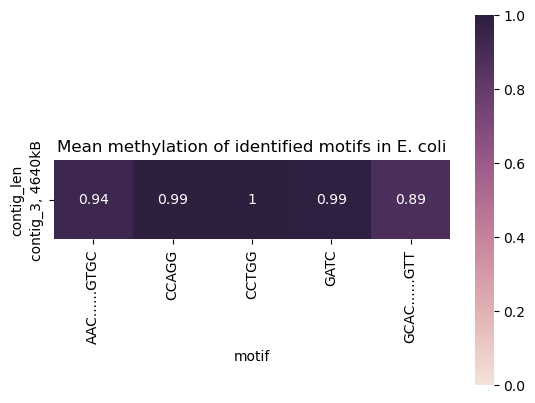

In [6]:
ec_motifs_plot = ec_motifs \
    .with_columns([
        pl.col("model").apply(lambda model: model.mean()).alias("mean"),
        pl.col("contig").apply(lambda contig: f"{contig}, {len(ec_assembly.assembly[contig])/ 1e3:.0f}kB").alias("contig_len"),
    ]).sort("motif", descending = True)
cmap = sns.cubehelix_palette(as_cmap=True, light=.9)
heatmap = sns.heatmap(ec_motifs_plot.to_pandas().pivot(values = "mean", index = "contig_len", columns = "motif"), 
                      cmap = cmap, square=True, vmin = 0, vmax = 1, annot = True);
heatmap.set_facecolor('lightgray');
plt.title("Mean methylation of identified motifs in E. coli");
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=90);

# M. ruber

In [2]:
mr_assembly = nm.load_assembly("../data/mruber/assembly.polished.fasta")
mr_pileup = nm.load_pileup("../data/mruber/modkit.pileup.bed")

In [3]:
mr_motifs = nm.evaluate.process_sample(mr_assembly, mr_pileup.pileup, min_cdf_score = 0.6, min_read_methylation_fraction = 0.85)

INFO: Processing a
INFO: Processing contig_1
DEBUG: ....................A.................... | cdf score: 0.000 | mean: 0.045 | n seqs:    44398 | max kl: inf
DEBUG: ...................GA.................... | cdf score: 0.000 | mean: 0.089 | n seqs:    36760 | max kl: 0.464
DEBUG: ...................GAG................... | cdf score: 0.000 | mean: 0.128 | n seqs:    24767 | max kl: 0.644
DEBUG: .................T.GAG................... | cdf score: 0.000 | mean: 0.277 | n seqs:    12823 | max kl: 1.029
DEBUG: .................TCGAG................... | cdf score: 0.000 | mean: 0.518 | n seqs:    10888 | max kl: 0.975
DEBUG: ................CTCGAG................... | cdf score: 1.000 | mean: 0.710 | n seqs:    10729 | max kl: 1.026
DEBUG: Saving candidate
DEBUG: ....................A.................... | cdf score: 0.000 | mean: 0.045 | n seqs:    33693 | max kl: inf
DEBUG: ....................AT................... | cdf score: 0.000 | mean: 0.093 | n seqs:    26055 | max kl: 0.619

In [5]:
mr_motifs

padded_motif,model,cdf_score,contig,mod_type,motif,mod_position
str,object,f64,str,str,str,i64
"""..............…","BetaBernoulliModel(alpha=9880, beta=4028)",1.0,"""contig_1""","""a""","""CTCGAG""",4
"""..............…","BetaBernoulliModel(alpha=10125, beta=7079)",1.0,"""contig_1""","""a""","""GATC""",1
"""..............…","BetaBernoulliModel(alpha=4623, beta=1213)",1.0,"""contig_1""","""a""","""AATT""",1
"""..............…","BetaBernoulliModel(alpha=1702, beta=154)",1.0,"""contig_1""","""a""","""GGGAGC""",3
"""..............…","BetaBernoulliModel(alpha=3514, beta=906)",1.0,"""contig_1""","""a""","""TTAA""",3
"""..............…","BetaBernoulliModel(alpha=1208, beta=23)",1.0,"""contig_1""","""a""","""GGCA......TGG""",3
"""..............…","BetaBernoulliModel(alpha=1007, beta=224)",1.0,"""contig_1""","""a""","""CCA......TGCC""",2


DEBUG: locator: <matplotlib.ticker.AutoLocator object at 0x7f38c68a0550>


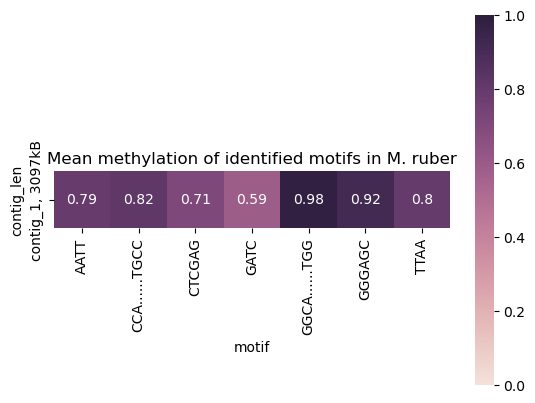

In [8]:
mr_motifs_plot = mr_motifs \
    .with_columns([
        pl.col("model").apply(lambda model: model.mean()).alias("mean"),
        pl.col("contig").apply(lambda contig: f"{contig}, {len(mr_assembly.assembly[contig])/ 1e3:.0f}kB").alias("contig_len"),
    ]).sort("motif", descending = True)
cmap = sns.cubehelix_palette(as_cmap=True, light=.9)
heatmap = sns.heatmap(mr_motifs_plot.to_pandas().pivot(values = "mean", index = "contig_len", columns = "motif"), 
                      cmap = cmap, square=True, vmin = 0, vmax = 1, annot = True);
heatmap.set_facecolor('lightgray');
plt.title("Mean methylation of identified motifs in M. ruber");

# Geobacillus

In [15]:
gb_assembly = nm.load_assembly("../data/geobacillus/assembly.polished.fasta")
gb_pileup = nm.load_pileup("../data/geobacillus/modkit.pileup.bed")

In [20]:
gb_motifs = nm.evaluate.process_sample(gb_assembly, gb_pileup.pileup, min_read_methylation_fraction = 0.85)

INFO: Processing a
INFO: Processing contig_3
DEBUG: ....................A.................... | cdf score: 0.000 | mean: 0.024 | n seqs:      699 | max kl: inf
DEBUG: ....................A.C.................. | cdf score: 0.000 | mean: 0.053 | n seqs:      677 | max kl: 1.000
DEBUG: ...................GA.C.................. | cdf score: 0.000 | mean: 0.247 | n seqs:      579 | max kl: 1.005
DEBUG: ...................GATC.................. | cdf score: 1.000 | mean: 0.718 | n seqs:      512 | max kl: 1.212
DEBUG: Saving candidate
DEBUG: ....................A.................... | cdf score: 0.000 | mean: 0.024 | n seqs:      187 | max kl: inf
DEBUG: .................C..A.................... | cdf score: 0.000 | mean: 0.025 | n seqs:      165 | max kl: 0.579
DEBUG: ................CC..A.................... | cdf score: 0.000 | mean: 0.045 | n seqs:      112 | max kl: 0.649
DEBUG: ................CC..AT................... | cdf score: 0.000 | mean: 0.138 | n seqs:       65 | max kl: 1.212

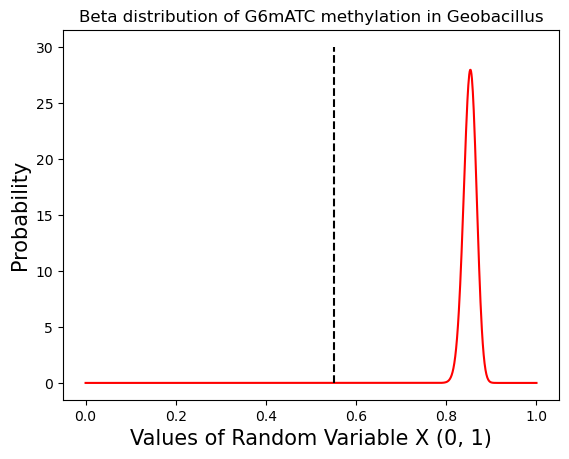

In [19]:
gb_motifs.filter(pl.col("motif") == "GATC").filter(pl.col("contig") == "contig_3")[0, 1].plot();
plt.vlines(0.55, 0, 30, color="black", linestyle="dashed");
plt.title("Beta distribution of G6mATC methylation in Geobacillus");

DEBUG: locator: <matplotlib.ticker.AutoLocator object at 0x7f38c694aac0>


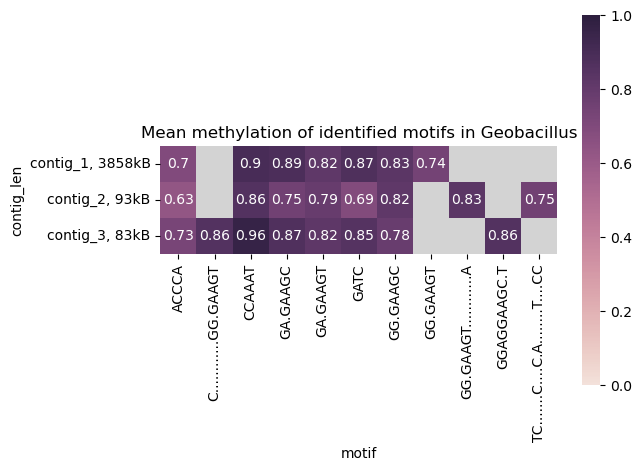

In [18]:
log.basicConfig(level=log.INFO);
gb_motifs_plot = gb_motifs \
    .with_columns([
        pl.col("model").apply(lambda model: model.mean()).alias("mean"),
        pl.col("contig").apply(lambda contig: f"{contig}, {len(gb_assembly.assembly[contig])/ 1e3:.0f}kB").alias("contig_len"),
    ]).sort("motif", descending = True)
cmap = sns.cubehelix_palette(as_cmap=True, light=.9)
heatmap = sns.heatmap(gb_motifs_plot.to_pandas().pivot(values = "mean", index = "contig_len", columns = "motif"), 
                      cmap = cmap, square=True, vmin = 0, vmax = 1, annot = True);
heatmap.set_facecolor('lightgray')
plt.title("Mean methylation of identified motifs in Geobacillus");

# E. coli -dcm/-dam

In [7]:
ecneg_assembly = nm.load_assembly("../data/ecoli_neg/assembly.polished.fasta")
ecneg_pileup = nm.load_pileup("../data/ecoli_neg/modkit.pileup.bed")

In [10]:
ecneg_motifs = nm.evaluate.process_sample(ecneg_assembly, ecneg_pileup.pileup, min_read_methylation_fraction = 0.4)

INFO: Processing m
INFO: Processing contig_1
DEBUG: ....................C.................... | cdf score: 0.000 | mean: 0.001 | n seqs:     2302 | max kl: inf
DEBUG: ...........G........C.................... | cdf score: 0.000 | mean: 0.002 | n seqs:     1431 | max kl: 0.762
DEBUG: ...........G........C.G.................. | cdf score: 0.000 | mean: 0.003 | n seqs:     1175 | max kl: 0.492
DEBUG: ...........G.......GC.G.................. | cdf score: 0.000 | mean: 0.008 | n seqs:      754 | max kl: 0.530
DEBUG: ...........G......CGC.G.................. | cdf score: 0.000 | mean: 0.018 | n seqs:      526 | max kl: 0.527
DEBUG: ...........GG.....CGC.G.................. | cdf score: 0.000 | mean: 0.060 | n seqs:      364 | max kl: 0.518
DEBUG: ...........GG.....CGC.G...G.............. | cdf score: 0.000 | mean: 0.112 | n seqs:      254 | max kl: 0.259
DEBUG: Too few sequences left
DEBUG: ....................C.................... | cdf score: 0.000 | mean: 0.001 | n seqs:     2160 | max k

In [11]:
ecneg_motifs

motif,mod_position,mod_type,cdf_score
f32,f32,f32,f32


# Combining results

DEBUG: locator: <matplotlib.ticker.AutoLocator object at 0x7f2240289040>


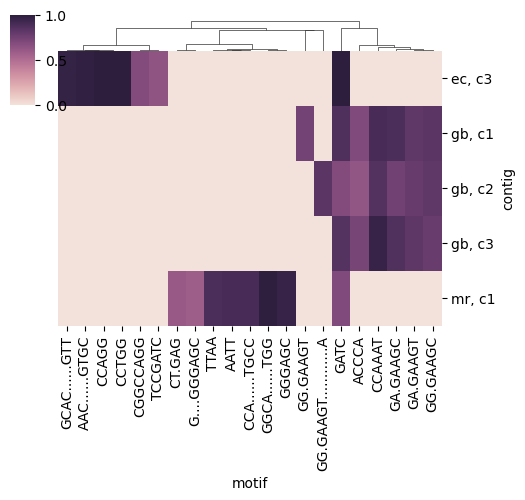

In [88]:
motifs_all_samples = pl.concat(
    [
        gb_motifs_plot.with_columns(pl.lit("gb").alias("species")),
        mr_motifs_plot.with_columns(pl.lit("mr").alias("species")),
        ec_motifs_plot.with_columns(pl.lit("ec").alias("species"))
    ]
) \
.with_columns(
    (pl.col("species") + ", " + pl.col("contig").str.replace("contig_", "c")).alias("contig")
).sort("species", descending = True)

cmap = sns.cubehelix_palette(as_cmap=True, light=.9)
heatmap = sns.clustermap(
    motifs_all_samples.to_pandas().pivot(values = "mean", index = "contig", columns = "motif").fillna(0), 
    cmap = cmap, vmin = 0, vmax = 1,
    row_cluster=False, col_cluster=True, dendrogram_ratio=0.1, figsize = (5, 5));
heatmap.ax_heatmap.yaxis.set_ticklabels(heatmap.ax_heatmap.yaxis.get_ticklabels(), rotation=0, ha='left');

In [13]:
arr1 = np.array([[1, 4, 3], [1, 3, 3], [2, 5, 3], [1, 4, 3]])
arr2 = np.array([1, 4, 3])
print(arr1.shape)
index = np.any(arr1[:, 1:3] != arr2[1:3], axis = 1)
print(index)
arr1[index, :]


(4, 3)
[False  True  True False]


array([[1, 3, 3],
       [2, 5, 3]])

In [6]:
test = nm.evaluate.convert_seqeunce_to_numpy(["AGCTAACG", "TGCTAACG", "AGCTAACG"])

In [5]:
nm.evaluate.subset_DNA_array(test, "A.......")

array([[1, 2, 3, 1, 0, 0, 3, 2]])

In [9]:
test

array([[0, 2, 3, 1, 0, 0, 3, 2],
       [1, 2, 3, 1, 0, 0, 3, 2],
       [0, 2, 3, 1, 0, 0, 3, 2]])

In [8]:

test.transpose()

array([[0, 1, 0],
       [2, 2, 2],
       [3, 3, 3],
       [1, 1, 1],
       [0, 0, 0],
       [0, 0, 0],
       [3, 3, 3],
       [2, 2, 2]])